# 1.2 Visualize the Optimization Process

## Import libraries

In [23]:
!nvidia-smi

Tue Feb  6 19:50:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:3B:00.0 Off |                  Off |
| 30%   27C    P8              30W / 300W |   2992MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

/tmp/ipykernel_2705141/2653462923.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [4]:
torch.cuda.is_available()

True

## Define and Plot Function

In [5]:
def fn(x):
    return torch.sin(5*torch.pi*x)/(5*torch.pi*x)

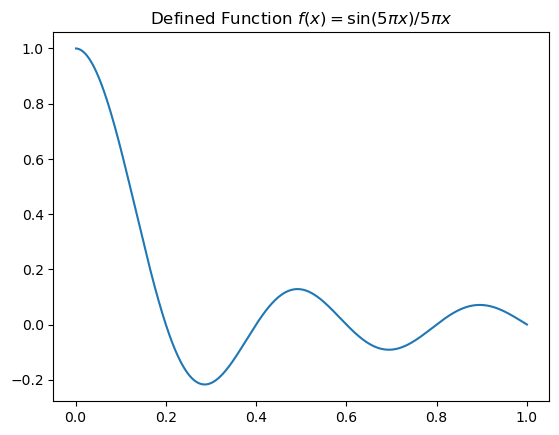

In [6]:
### Plot fn
xvec = torch.linspace(0,1,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec, label = "function")
plt.title("Defined Function $f(x)=\sin(5\pi x)/5\pi x$")
plt.show()

## Load Data

In [7]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


## View Image

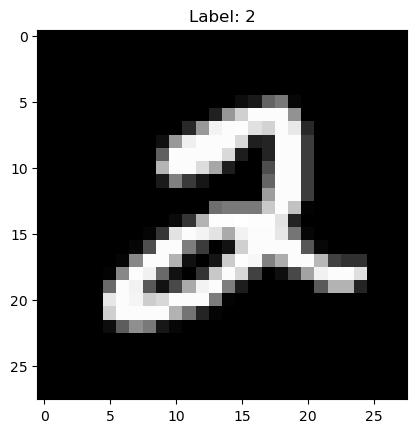

In [8]:
# Choose an image index
image_index = 5  # You can change this to any valid index

# Get the image and label
image, label = train_dataset[image_index]

# Convert the image tensor to a numpy array
image_array = image.numpy()

# Reshape the array to 28x28
image_array = image_array.reshape(28, 28)

# Display the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Define Model Class

In [9]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        x = x.view(-1, 784)
        for layer in self.layers:
            x = layer(x)
        return x

## Train & Eval Function
### With collecting model params

In [21]:
### training function
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # load model to GPU
    model = model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    model_weights = pd.DataFrame()
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        print(f"train loss: {train_loss}")

        # Collect parameters
        #weights = [p.data.clone() for p in model.parameters()]
        temp_wts = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().cpu().numpy()
                temp_wts = pd.concat([temp_wts, pd.DataFrame(weights).T], axis = 1)
        model_weights = pd.concat([model_weights,temp_wts], axis = 0)
        
        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        #print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, model_weights

## Specify Model

In [18]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

## Train Model

In [12]:
#m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
#                             , test_loader=test_loader)

In [13]:
##m1_weights.head()
#wts = np.array(m1_weights)

In [19]:
# check model parameter number
model1_parameters = []
for name, param in model1.named_parameters():
    if 'weight' in name:
        model1_parameters.append(param.T.shape[0])
print(model1_parameters)
sum = 0
for l in range(0,len(model1_parameters)-1):
    sum += model1_parameters[l] * model1_parameters[l+1]
sum += model1_parameters[-1]*10 # last output layer
print(sum)

[784, 17, 26, 25, 23, 12]
15391


In [15]:
'''df_temp = m1_weights.copy()
df_temp['loss'] = np.array([x.detach().numpy() for x in m1_loss])
df_temp['accuracy'] = m1_acc
df_temp.head()'''

"df_temp = m1_weights.copy()\ndf_temp['loss'] = np.array([x.detach().numpy() for x in m1_loss])\ndf_temp['accuracy'] = m1_acc\ndf_temp.head()"

In [25]:
df = pd.DataFrame()
for i in range(8):
    model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])
    m1_loss, m1_acc, m1_weights = train_eval(model1, num_epochs=30, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)
    df_temp = m1_weights.copy()
    df_temp['loss'] = np.array([x.detach().cpu().numpy() for x in m1_loss])
    df_temp['accuracy'] = m1_acc
    df = pd.concat([df, df_temp], axis = 0).reset_index(drop = True)
df.head()

train loss: 0.6811187863349915
train loss: 0.32840240001678467
train loss: 0.24870389699935913
train loss: 0.21025846898555756
train loss: 0.18315614759922028
train loss: 0.16969364881515503
train loss: 0.155549556016922
train loss: 0.14757558703422546
train loss: 0.13835422694683075
train loss: 0.13256171345710754
train loss: 0.12760882079601288
train loss: 0.11999766528606415
train loss: 0.11633960902690887
train loss: 0.11339687556028366
train loss: 0.11067065596580505
train loss: 0.10623198002576828
train loss: 0.10414467006921768
train loss: 0.10094425827264786
train loss: 0.09915794432163239
train loss: 0.09555910527706146
train loss: 0.09422306716442108
train loss: 0.09144144505262375
train loss: 0.0892670750617981
train loss: 0.08926340937614441
train loss: 0.08494500070810318
train loss: 0.08408436924219131
train loss: 0.08158966898918152
train loss: 0.08069834858179092
train loss: 0.0767289325594902
train loss: 0.07524118572473526
train loss: 0.6157678365707397
train loss: 0.

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,loss,accuracy
0,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,-0.355737,-0.005128,-0.056339,0.312648,-0.181056,0.277824,-0.227173,-0.211712,0.681119,88.18
1,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,-0.343765,-0.030169,-0.056339,0.392566,-0.174403,0.270517,-0.265241,-0.140504,0.328402,92.39
2,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,-0.356491,-0.056109,-0.056339,0.391368,-0.170255,0.262495,-0.285211,-0.074354,0.248704,94.05
3,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,-0.377761,-0.065785,-0.056339,0.397473,-0.156696,0.257031,-0.296899,-0.015094,0.210258,94.13
4,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,-0.398856,-0.093667,-0.056339,0.390470,-0.177138,0.250157,-0.310766,0.023612,0.183156,94.89


Add Accuracy and Loss columns to the weights data frame.

## PCA

In [26]:
df_pca = df.drop(["loss", "accuracy"], axis = 1).reset_index(drop = True)
print(df_pca.shape)
df_pca.head()

(240, 15391)


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,0.149687,0.151178,-0.355737,-0.005128,-0.056339,0.312648,-0.181056,0.277824,-0.227173,-0.211712
1,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,0.150045,0.149271,-0.343765,-0.030169,-0.056339,0.392566,-0.174403,0.270517,-0.265241,-0.140504
2,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,0.147906,0.145145,-0.356491,-0.056109,-0.056339,0.391368,-0.170255,0.262495,-0.285211,-0.074354
3,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,0.146497,0.164840,-0.377761,-0.065785,-0.056339,0.397473,-0.156696,0.257031,-0.296899,-0.015094
4,0.035437,0.00119,0.007935,-0.011306,0.02005,0.014416,0.003872,-0.002383,-0.024302,0.034647,...,0.141732,0.175203,-0.398856,-0.093667,-0.056339,0.390470,-0.177138,0.250157,-0.310766,0.023612


In [27]:
df_pca = np.array(df_pca)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df_pca)

In [28]:

df_full = pd.DataFrame(new_data, columns=['x','y'])
df_full['Accuracy'] = df['accuracy'].reset_index(drop = True)
df_full['Loss'] = df['loss'].reset_index(drop = True)
#df_full.head()
df_full = df_full.iloc[::3, :]

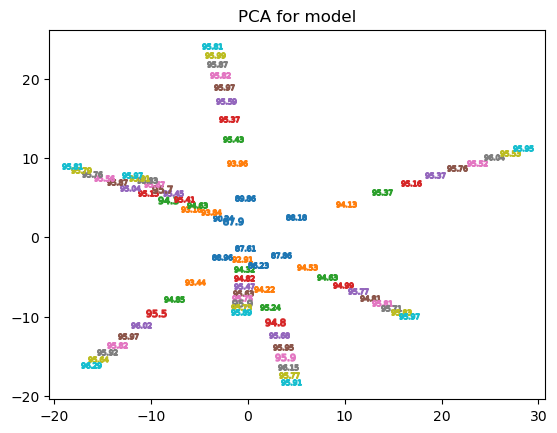

In [29]:
for i in range(80):
    m = list(df_full['Accuracy'])[i]
    plt.scatter(df_full['x'][i*3], df_full['y'][i*3], s = 200, marker = f'${m}$')
    plt.title("PCA for model")

## Gradient Norm

In [126]:
def gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

## Train & Eval Function
### With gradient norm function

In [ ]:
### training function for MNIST data set
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    gradient = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)
        gradient.append(gradient_norm(model))
        print(f"train loss: {train_loss}")

        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
    return total_loss, total_accuracy, gradient

In [ ]:
### Training function for training on fn(x)
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):
  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()
  
  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  gradient = []
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      loss_vec.append(epoch_loss)
      gradient.append(gradient_norm(model))
  return loss_vec, gradient

In [ ]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [17, 26, 25, 23, 12])

In [ ]:
### Train on MNIST
m1_loss, m1_acc, m1_grad = train_eval(model1, num_epochs=2, learning_rate=0.001, train_loader=train_loader
                             , test_loader=test_loader)

In [ ]:
### Train on fn(x)
x_train = torch.linspace(0,1,1000)
y_train = fn(x_train)
# Train the model
model1_loss, model1_grad = train_model(model1, x_train, y_train, batch = 50, epochs = 10, learning_rate = 0.001)